## Download the data

In [78]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  20.4M      0  0:00:36  0:00:36 --:--:-- 21.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  7857k      0  0:00:02  0:00:02 --:--:-- 7857k


## Prepare paths of input images and target segmentation masks

In [79]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (256, 256)
num_classes = 3
batch_size = 32
mask_name = ['Cat', 'Dog']

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

num_samples = len(input_img_paths)
print("Number of samples:", num_samples)

for input_path, target_path in zip(input_img_paths[4000:4005], target_img_paths[4000:4005]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/german_shorthaired_1.jpg | annotations/trimaps/german_shorthaired_1.png
images/german_shorthaired_10.jpg | annotations/trimaps/german_shorthaired_10.png
images/german_shorthaired_100.jpg | annotations/trimaps/german_shorthaired_100.png
images/german_shorthaired_101.jpg | annotations/trimaps/german_shorthaired_101.png
images/german_shorthaired_102.jpg | annotations/trimaps/german_shorthaired_102.png


In [80]:
# Разделим породы котов и собак
breeds = []
for x in input_img_paths:
  filename = x.split('/')[1]
  last = filename.split('_')[-1]
  breed_name = filename[:-len(last)-1]
  breeds.append(breed_name)

breed_list = list(set(breeds))
breed_list.sort()
cats_breed_set = set([x for x in breed_list if x[0] >= 'A' and x[0] <= 'Z'])
dogs_breed_set = cats_breed_set.symmetric_difference(breed_list)
# cats_breed_set, dogs_breed_set

In [81]:
# переназначим сегментационные метки для разделения кошек и собак
# кот     1 -> 1
# собака  1 -> 2
# фон     2 -> 0
# контур  3 -> 1
def transfer_segments(mask, path):
  mask[np.where((mask==[3]).all(axis=2))] = [1]
  mask[np.where((mask==[2]).all(axis=2))] = [0]
  if is_cat(path):
    mask[np.where((mask==[1]).all(axis=2))] = [1]
  else:
    mask[np.where((mask==[1]).all(axis=2))] = [2]
  return mask


# по названию файла (target) определяется, кошка ли это
def is_cat(path):
  filename = path.split('/')[2]
  last = filename.split('_')[-1]
  breed_name = filename[:-len(last)-1]
  return breed_name in cats_breed_set

In [82]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            y[j] = transfer_segments(y[j], path)
        return x, y

In [83]:
import random

# Split our img paths into a training and a validation set
val_samples = 800
test_samples = 800
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-2*val_samples:-test_samples]
val_target_img_paths = target_img_paths[-2*val_samples:-test_samples]
test_input_img_paths = input_img_paths[-test_samples:]
test_target_img_paths = target_img_paths[-test_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

test_gen = OxfordPets(batch_size, img_size, test_input_img_paths, test_target_img_paths)

## Prepare U-Net model

In [45]:
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import *

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    # x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    # x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D(3, strides=2, padding="same")(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    # x = Dropout(0.5)(x)
    x = conv_block(x, num_filters)
    return x

def build_unet():
    inputs = Input(shape=img_size + (3,))

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b = conv_block(p4, 256)

    d1 = decoder_block(b, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    outputs = Conv2D(num_classes, 3, activation="softmax", padding="same")(d4)

    model = keras.Model(inputs, outputs)
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = build_unet()
# model.summary()

## Train the model

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoint1.h5")
]

epochs = 15
history1 = model.fit(train_gen, validation_data=val_gen, batch_size=batch_size, epochs=epochs, callbacks=callbacks)

Epoch 1/15
205/205 [==============================] - 169s 633ms/step - loss: 1.0543 - val_loss: 0.8268
Epoch 2/15
205/205 [==============================] - 129s 628ms/step - loss: 0.8295 - val_loss: 0.7596
Epoch 3/15
205/205 [==============================] - 129s 628ms/step - loss: 0.7631 - val_loss: 0.8134
Epoch 4/15
205/205 [==============================] - 129s 630ms/step - loss: 0.7056 - val_loss: 0.7734
Epoch 5/15
205/205 [==============================] - 129s 629ms/step - loss: 0.6632 - val_loss: 0.8247
Epoch 6/15
205/205 [==============================] - 129s 629ms/step - loss: 0.6243 - val_loss: 0.6403
Epoch 7/15
205/205 [==============================] - 129s 629ms/step - loss: 0.5934 - val_loss: 0.6236
Epoch 8/15
205/205 [==============================] - 129s 629ms/step - loss: 0.5779 - val_loss: 0.5362
Epoch 9/15
205/205 [==============================] - 129s 631ms/step - loss: 0.5640 - val_loss: 0.5152
Epoch 10/15
205/205 [==============================] - 129s 629m

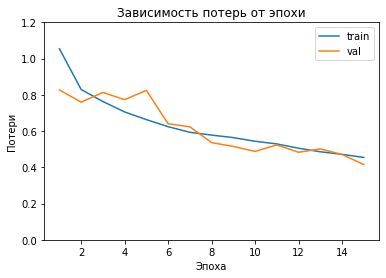

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), history1.history['loss'], label='train')
plt.plot(range(1, epochs + 1), history1.history['val_loss'], label='val')
plt.ylim(0, 1.2)
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Зависимость потерь от эпохи')
plt.legend()
plt.show()

## Визуализация предсказаний

In [46]:
from numpy import asarray
from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.load_weights('/content/drive/MyDrive/checkpoint1.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
# вывод маски и изображения
def show_mask(pred, val_input_img_paths):
    mask_ = np.argmax(pred, axis=-1)
    mask_ = np.expand_dims(mask_, axis=-1)
    
    mask = np.zeros(img_size + (3,), dtype=np.uint8)
    mask[np.where((mask_==2).all(axis=2))] = [150,70,70]  # красный - коты
    mask[np.where((mask_==1).all(axis=2))] = [70,150,70]  # зеленый - собаки
    
    # print('№', i)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.axis('off')
    ax1.imshow(mask.astype(np.uint8))
    ax1.set_title('Mask')
    ax2.imshow(asarray(load_img(val_input_img_paths)).astype(np.uint8))
    ax2.set_title('Image')
    ax1.set_axis_off()
    ax2.set_axis_off()
    plt.show()

# простая классификация на основе сегментационной маски
def get_classification(pred, mess='on'):
    mask = np.argmax(pred, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    cat_pixels = (mask==1).all(axis=2).sum()
    dog_pixels = (mask==2).all(axis=2).sum()
    back_pixels = (mask==0).all(axis=2).sum()
    sum_pixels = cat_pixels + dog_pixels + back_pixels

    cat_prop = cat_pixels / sum_pixels
    dog_prop = dog_pixels / sum_pixels

    class_ = 0 if cat_prop > dog_prop else 1
    
    if mess == 'on':
        print('Proportions of dog / cat:')
        print(round(cat_prop, 3), '/', round(dog_prop, 3))
        print('This is:')
        print(mask_name[class_])
    return class_

In [47]:
# train_preds = model.predict(train_gen)
val_preds = model.predict(val_gen)
test_preds = model.predict(test_gen)

### Предсказания на валидационной выборке

---------------------------------------------
№ 3
Proportions of dog / cat:
0.116 / 0.041
This is:
Cat


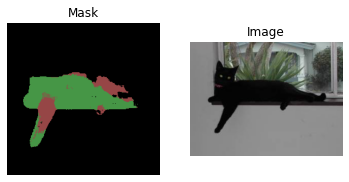

---------------------------------------------
№ 4
Proportions of dog / cat:
0.0 / 0.249
This is:
Dog


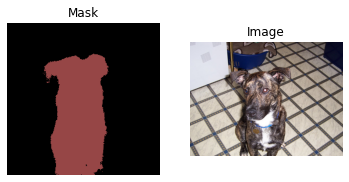

---------------------------------------------
№ 5
Proportions of dog / cat:
0.0 / 0.167
This is:
Dog


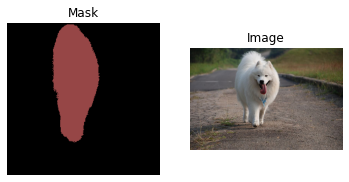

---------------------------------------------
№ 6
Proportions of dog / cat:
0.098 / 0.289
This is:
Dog


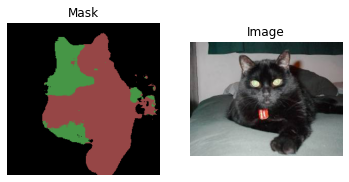

---------------------------------------------
№ 7
Proportions of dog / cat:
0.016 / 0.367
This is:
Dog


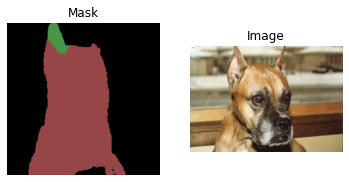

---------------------------------------------
№ 8
Proportions of dog / cat:
0.001 / 0.541
This is:
Dog


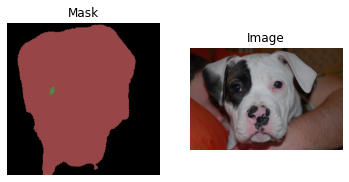

---------------------------------------------
№ 9
Proportions of dog / cat:
0.005 / 0.253
This is:
Dog


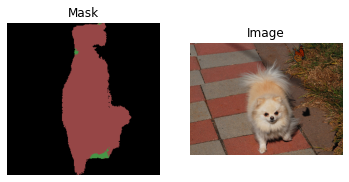

In [127]:
for i in range(3,10):
  print('---------------------------------------------')
  print('№', i)
  get_classification(val_preds[i])
  show_mask(val_preds[i], val_input_img_paths[i])

### Предсказания на тестовой выборке

---------------------------------------------
№ 6
Proportions of dog / cat:
0.123 / 0.074
This is:
Cat


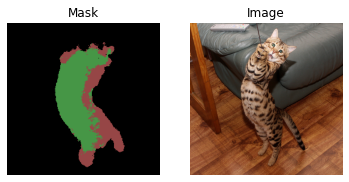

---------------------------------------------
№ 7
Proportions of dog / cat:
0.009 / 0.372
This is:
Dog


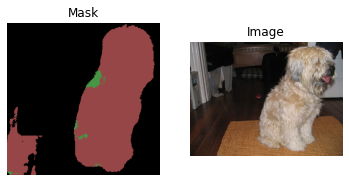

---------------------------------------------
№ 8
Proportions of dog / cat:
0.005 / 0.306
This is:
Dog


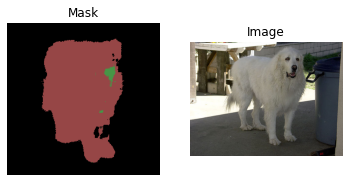

---------------------------------------------
№ 9
Proportions of dog / cat:
0.247 / 0.072
This is:
Cat


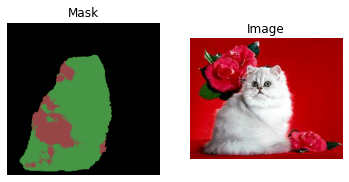

---------------------------------------------
№ 10
Proportions of dog / cat:
0.055 / 0.284
This is:
Dog


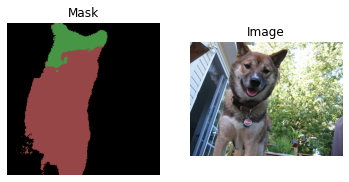

---------------------------------------------
№ 11
Proportions of dog / cat:
0.028 / 0.413
This is:
Dog


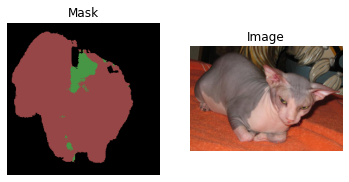

---------------------------------------------
№ 12
Proportions of dog / cat:
0.0 / 0.462
This is:
Dog


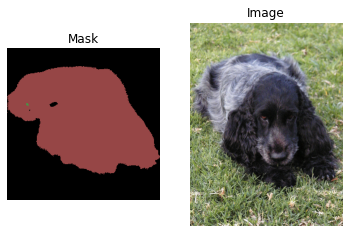

---------------------------------------------
№ 13
Proportions of dog / cat:
0.017 / 0.331
This is:
Dog


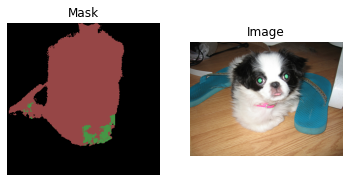

---------------------------------------------
№ 14
Proportions of dog / cat:
0.181 / 0.229
This is:
Dog


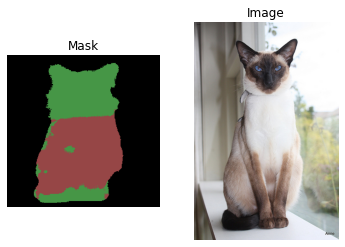

In [126]:
for i in range(6,15):
  print('---------------------------------------------')
  print('№', i)
  get_classification(test_preds[i])
  show_mask(test_preds[i], test_input_img_paths[i])

## Оценка классификации через сегментацию U-net

In [85]:
# Истинные метки классов
train_true_class = [None]*len(train_target_img_paths)
for i in range(len(train_target_img_paths)):
  train_true_class[i] = int(not is_cat(train_target_img_paths[i]))

val_true_class = [None]*len(val_target_img_paths)
for i in range(len(val_target_img_paths)):
  val_true_class[i] = int(not is_cat(val_target_img_paths[i]))

test_true_class = [None]*len(test_target_img_paths)
for i in range(len(test_target_img_paths)):
  test_true_class[i] = int(not is_cat(test_target_img_paths[i]))

In [49]:
from sklearn.metrics import accuracy_score

def calculate_acc(preds):
  class_preds = np.zeros(len(preds))
  for i in range(len(preds)):
      class_preds[i] = get_classification(preds[i], 'off')
  return class_preds

In [14]:
results_acc = np.zeros((2,2), dtype='float32')

In [52]:
val_pred_class = calculate_acc(val_preds)
print('Точность классификации на валидационной выборке:')
results_acc[0][0] = accuracy_score(val_true_class, val_pred_class)
results_acc[0][0]

Точность классификации на валидационной выборке:


0.8325

In [53]:
test_pred_class = calculate_acc(test_preds)
print('Точность классификации на тестовой выборке:')
results_acc[0][1] = accuracy_score(test_true_class, test_pred_class)
results_acc[0][1]

Точность классификации на тестовой выборке:


0.815

## Вторая сеть для классификации

In [8]:
from tensorflow.keras import layers

keras.backend.clear_session()

model2 = keras.Sequential(
    [
        keras.Input(shape=img_size + (3,)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),  
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),  
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),  
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),  
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes-1, activation="softmax"),
    ]
)
model2.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])
# model2.summary()

In [9]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPetsClassification(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            y[j] = int(not is_cat(path)) # метка класса
        y = keras.utils.to_categorical(y, num_classes-1)
        return x, y

train_gen_class = OxfordPetsClassification(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen_class = OxfordPetsClassification(batch_size, img_size, val_input_img_paths, val_target_img_paths)

test_gen_class = OxfordPetsClassification(batch_size, img_size, test_input_img_paths, test_target_img_paths)

## Обучение второй сети

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint("simple_mnist.h5", save_best_only=True)
]

epochs = 15
history2 = model2.fit(
    train_gen_class, validation_data=val_gen_class, 
    batch_size=batch_size, epochs=epochs, callbacks=callbacks
)

Epoch 1/15
205/205 [==============================] - 84s 246ms/step - loss: 1.2803 - accuracy: 0.6428 - val_loss: 0.5394 - val_accuracy: 0.7625
Epoch 2/15
205/205 [==============================] - 50s 245ms/step - loss: 0.8232 - accuracy: 0.7284 - val_loss: 0.3999 - val_accuracy: 0.8200
Epoch 3/15
205/205 [==============================] - 50s 244ms/step - loss: 0.6515 - accuracy: 0.7721 - val_loss: 0.3452 - val_accuracy: 0.8575
Epoch 4/15
205/205 [==============================] - 50s 244ms/step - loss: 0.4965 - accuracy: 0.8178 - val_loss: 0.2548 - val_accuracy: 0.9025
Epoch 5/15
205/205 [==============================] - 50s 243ms/step - loss: 0.3897 - accuracy: 0.8514 - val_loss: 0.2298 - val_accuracy: 0.9050
Epoch 6/15
205/205 [==============================] - 50s 245ms/step - loss: 0.3487 - accuracy: 0.8677 - val_loss: 0.1723 - val_accuracy: 0.9325
Epoch 7/15
205/205 [==============================] - 50s 243ms/step - loss: 0.2862 - accuracy: 0.8928 - val_loss: 0.1132 - val_ac

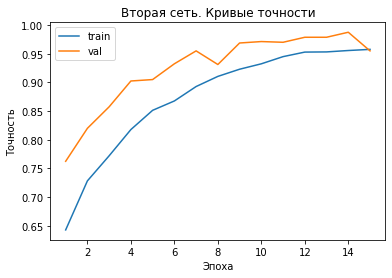

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), history2.history['accuracy'], label='train')
plt.plot(range(1, epochs + 1), history2.history['val_accuracy'], label='val')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Вторая сеть. Кривые точности')
plt.legend()
plt.show()

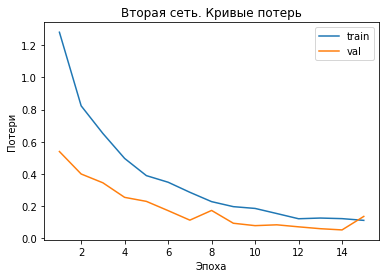

In [12]:
plt.plot(range(1, epochs + 1), history2.history['loss'], label='train')
plt.plot(range(1, epochs + 1), history2.history['val_loss'], label='val')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Вторая сеть. Кривые потерь')
plt.legend()
plt.show()

## Сравнение точности классификаторов

In [86]:
from google.colab import drive

drive.mount('/content/drive')
model2.load_weights('/content/drive/MyDrive/simple_mnist.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Точность модели для классификации
results_acc[1][0] = np.round(model2.evaluate(val_gen_class)[1], 3)
results_acc[1][1] = np.round(model2.evaluate(test_gen_class)[1], 3)

25/25 [==============================] - 34s 1s/step - loss: 0.6896 - accuracy: 0.7937


In [54]:
import pandas as pd

# Сравнение точностей двух классификаторов: 
# классификатор через сегментацию U-net и через простую сеть
table_acc = pd.DataFrame({'NET': ['U-net', 'Simple net'], 
                          'VAL':results_acc.T[0], 
                          'TEST':results_acc.T[1]})
table_acc

,NET,VAL,TEST
0,U-net,0.8325,0.815
1,Simple net,0.9850,0.794


## Вывод ошибочной классификации второй моделью

In [87]:
val_pred_class = model2.predict(val_gen_class)
test_pred_class = model2.predict(test_gen_class)

In [92]:
val_pred_class[:,[0, 1]] = val_pred_class[:,[1, 0]]
test_pred_class[:,[0, 1]] = test_pred_class[:,[1, 0]]

In [100]:
fail_idx_val = np.where(np.argmax(val_pred_class, axis=-1) != val_true_class)[0]
print('Число ошибок на валидационной выборке: ', fail_idx_val.shape[0])

Число ошибок на валидационной выборке:  12


In [101]:
fail_idx_test = np.where(np.argmax(test_pred_class, axis=-1) != test_true_class)[0]
print('Число ошибок на тестовой выборке: ', fail_idx_test.shape[0])

Число ошибок на тестовой выборке:  165


№ 49
Cat (%) / Dog (%)
32% / 67%
This is: Dog


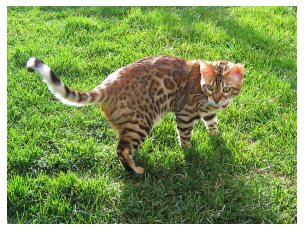

№ 62
Cat (%) / Dog (%)
55% / 44%
This is: Cat


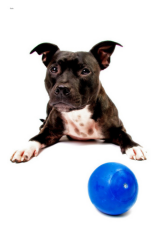

№ 169
Cat (%) / Dog (%)
53% / 46%
This is: Cat


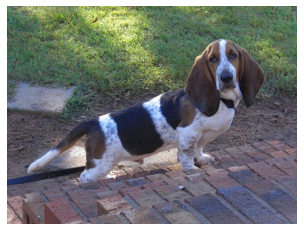

№ 282
Cat (%) / Dog (%)
30% / 69%
This is: Dog


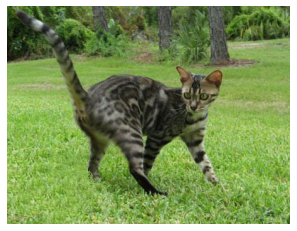

№ 396
Cat (%) / Dog (%)
29% / 70%
This is: Dog


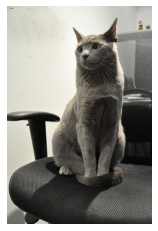

№ 444
Cat (%) / Dog (%)
72% / 27%
This is: Cat


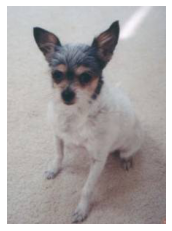

№ 575
Cat (%) / Dog (%)
58% / 41%
This is: Cat


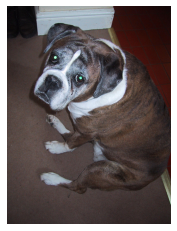

№ 688
Cat (%) / Dog (%)
66% / 33%
This is: Cat


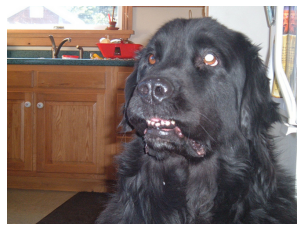

№ 786
Cat (%) / Dog (%)
36% / 63%
This is: Dog


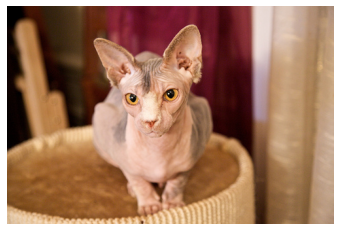

№ 790
Cat (%) / Dog (%)
65% / 34%
This is: Cat


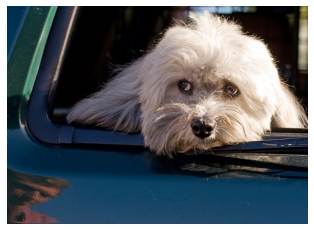

In [102]:
from numpy import asarray
import matplotlib.pyplot as plt


for i in fail_idx_val[:10]:
    print('№', i)
    pred1, pred2 = val_pred_class[i]*100
    print('Cat (%) / Dog (%)')
    print(str(int(pred1)) + '% / ' + str(int(pred2)) + '%')
    print('This is:', mask_name[np.argmax(val_pred_class[i], axis=-1)])
    plt.imshow(asarray(load_img(val_input_img_paths[i])).astype(np.uint8))
    plt.axis('off')
    plt.show()